# Prepare SST data for gender annotation

* Import SST data from huggingface
* Use word lists to automatically annotate (pre-annotate?) sentences for gender
* Subsample gendered sentences: 400 masculine, 400 feminine, 400 neutral
* Prepare CSVs for human annotation

## Import SST data from huggingface

In [1]:
import pandas as pd

In [2]:
from datasets import load_dataset

dataset = load_dataset("sst")

No config specified, defaulting to: sst/default
Reusing dataset sst (/Users/katygero/.cache/huggingface/datasets/sst/default/1.0.0/b8a7889ef01c5d3ae8c379b84cc4080f8aad3ac2bc538701cbe0ac6416fb76ff)


  0%|          | 0/3 [00:00<?, ?it/s]

In [3]:
#splits: ['test', 'train', 'validation']
dataset['train'][0]

{'sentence': "The Rock is destined to be the 21st Century 's new `` Conan '' and that he 's going to make a splash even greater than Arnold Schwarzenegger , Jean-Claud Van Damme or Steven Segal .",
 'label': 0.6944400072097778,
 'tokens': "The|Rock|is|destined|to|be|the|21st|Century|'s|new|``|Conan|''|and|that|he|'s|going|to|make|a|splash|even|greater|than|Arnold|Schwarzenegger|,|Jean-Claud|Van|Damme|or|Steven|Segal|.",
 'tree': '70|70|68|67|63|62|61|60|58|58|57|56|56|64|65|55|54|53|52|51|49|47|47|46|46|45|40|40|41|39|38|38|43|37|37|69|44|39|42|41|42|43|44|45|50|48|48|49|50|51|52|53|54|55|66|57|59|59|60|61|62|63|64|65|66|67|68|69|71|71|0'}

In [4]:
train = pd.DataFrame(dataset['train'])
train['split'] = 'train'

val = pd.DataFrame(dataset['validation'])
val['split'] = 'validation'

test = pd.DataFrame(dataset['test'])
test['split'] = 'test'

data = pd.concat([train, val, test])

In [5]:
pd.set_option('display.max_colwidth', 50)
data

,sentence,label,tokens,tree,split
0,The Rock is destined to be the 21st Century 's...,0.694440,The|Rock|is|destined|to|be|the|21st|Century|'s...,70|70|68|67|63|62|61|60|58|58|57|56|56|64|65|5...,train
1,The gorgeously elaborate continuation of `` Th...,0.833330,The|gorgeously|elaborate|continuation|of|``|Th...,71|70|69|69|67|67|66|64|63|62|62|61|61|58|57|5...,train
2,Singer\/composer Bryan Adams contributes a sle...,0.625000,Singer\/composer|Bryan|Adams|contributes|a|sle...,72|71|71|70|68|68|67|67|66|63|62|62|60|60|58|5...,train
3,You 'd think by now America would have had eno...,0.500000,You|'d|think|by|now|America|would|have|had|eno...,36|35|34|33|33|32|30|29|27|26|25|24|23|23|22|2...,train
4,Yet the act is still charming here .,0.722220,Yet|the|act|is|still|charming|here|.,15|13|13|10|9|9|11|12|10|11|12|14|14|15|0,train
...,...,...,...,...,...
2205,An imaginative comedy\/thriller .,0.777780,An|imaginative|comedy\/thriller|.,7|6|5|5|6|7|0,test
2206,"( A ) rare , beautiful film .",0.916670,"(|A|)|rare|,|beautiful|film|.",13|12|12|11|10|9|9|15|10|11|14|13|14|15|0,test
2207,( An ) hilarious romantic comedy .,0.888890,(|An|)|hilarious|romantic|comedy|.,12|11|11|9|8|8|10|9|10|13|12|13|0,test
2208,Never ( sinks ) into exploitation .,0.625000,Never|(|sinks|)|into|exploitation|.,11|10|9|9|8|8|13|12|10|11|12|13|0,test


## Loosely annotate sentences (masc, femme, neutral) using word lists

In [6]:
gender_words = {
    'femm': ['she', 'her', 'hers', 'mum', 'mom', 'mother', 'daughter', 'sister', 'niece', 'aunt', 'grandmother',
             'lady', 'woman', 'girl', "ma'am", 'female', 'wife', 'ms', 'miss', 'mrs', 'ms.', 'mrs.'],
    'masc': ['he', 'him', 'his', 'dad', 'father', 'son', 'brother', 'nephew', 'uncle', 'grandfather',
             'gentleman', 'man', 'boy', 'sir', 'male', 'husband', 'mr', 'mr.'],
    'neut': ['they', 'them', 'theirs', 'parent', 'child', 'sibling',
             'person', 'spouse']
}

def label_gender(row):
    tokens = row['tokens'].lower().split('|')
    gender = 'none'
    for key, words in gender_words.items():
        for w in words:
            if w in tokens or w+"s" in tokens:
                if gender == 'none':
                    gender = key
                else:
                    gender = 'mixed'
                break
    return gender

data['gender'] = data.apply(lambda row: label_gender(row), axis=1)

In [7]:
data['gender'].value_counts()

none     10001
masc       931
neut       420
femm       372
mixed      131
Name: gender, dtype: int64

In [8]:
data_polarized = data[(data['label']>.6)|(data['label']<.4)]
data_polarized['gender'].value_counts()

none     8113
masc      743
neut      350
femm      303
mixed     104
Name: gender, dtype: int64

In [14]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
data[['sentence', 'label', 'gender']][data['gender'] == 'masc'][:20]

,sentence,label,gender
0,"The Rock is destined to be the 21st Century 's new `` Conan '' and that he 's going to make a splash even greater than Arnold Schwarzenegger , Jean-Claud Van Damme or Steven Segal .",0.69444,masc
43,`` Auto Focus '' works as an unusual biopic and document of male swingers in the Playboy era,0.65278,masc
44,"If Mr. Zhang 's subject matter is , to some degree at least , quintessentially American , his approach to storytelling might be called Iranian .",0.52778,masc
52,"( City ) reminds us how realistically nuanced a Robert De Niro performance can be when he is not more lucratively engaged in the shameless self-caricature of ` Analyze This ' ( 1999 ) and ` Analyze That , ' promised ( or threatened ) for later this year .",0.63889,masc
90,Allen shows he can outgag any of those young whippersnappers making moving pictures today .,0.76389,masc
98,"It celebrates the group 's playful spark of nonconformity , glancing vividly back at what Hibiscus grandly called his ` angels of light . '",0.72222,masc
136,Writer\/director Alexander Payne ( Election ) and his co-writer Jim Taylor brilliantly employ their quirky and fearless ability to look American angst in the eye and end up laughing .,0.75000,masc
141,Pacino is the best he 's been in years and Keener is marvelous .,0.88889,masc
146,So purely enjoyable that you might not even notice it 's a fairly straightforward remake of Hollywood comedies such as Father of the Bride .,0.79167,masc
150,Robin Williams has thankfully ditched the saccharine sentimentality of Bicentennial Man in favour of an altogether darker side .,0.63889,masc


## Look at distribution of data

<AxesSubplot:xlabel='gender', ylabel='label'>

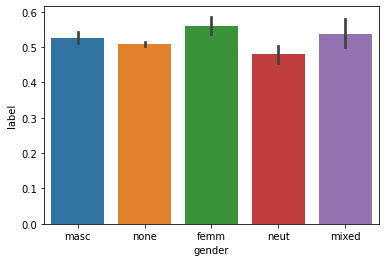

In [98]:
%matplotlib inline
import seaborn as sns

sns.barplot(data=data, x='gender', y='label')

<AxesSubplot:xlabel='gender', ylabel='count'>

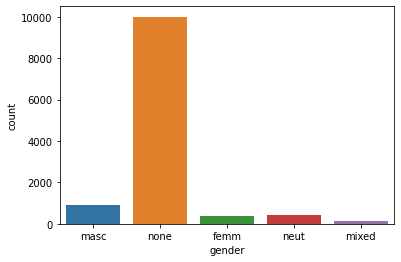

In [99]:
sns.countplot(data=data, x='gender')

<AxesSubplot:xlabel='gender', ylabel='count'>

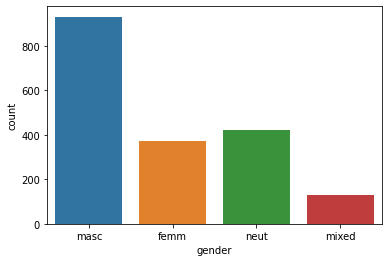

In [100]:
sns.countplot(data=data[data['gender']!='none'], x='gender')

## Subsample for 400 from each category (masc, femm, neut)

In [17]:
subbed_data = []
for genderword in ['masc', 'femm', 'neut']:
    local_data = data[data['gender'] == genderword]
    if local_data.shape[0] < 400:
        subbed_data.append(local_data)
    else:
        subbed_data.append(local_data.sample(n=400, replace=False))
        
# shuffle data using '.sample(frac=1)'
subsample_data = pd.concat(subbed_data).sample(frac=1).reset_index()


pd.reset_option('^display.', silent=True)

subsample_data

,index,sentence,label,tokens,tree,split,gender
0,8204,As pedestrian as they come .,0.18056,As|pedestrian|as|they|come|.,10|9|9|8|7|7|8|11|10|11|0,train,neut
1,2150,Oft-described as the antidote to American Pie-...,0.33333,Oft-described|as|the|antidote|to|American|Pie-...,55|54|53|53|52|51|50|49|49|48|47|46|43|41|41|4...,test,neut
2,3960,I have a confession to make : I did n't partic...,0.25000,I|have|a|confession|to|make|:|I|did|n't|partic...,44|43|42|41|40|40|45|39|36|36|37|34|34|32|31|3...,train,masc
3,1308,Either a fascinating study of the relationship...,0.50000,Either|a|fascinating|study|of|the|relationship...,42|38|37|37|36|34|34|33|33|40|30|30|31|28|27|2...,train,femm
4,2272,Manages to please its intended audience -- chi...,0.72222,Manages|to|please|its|intended|audience|--|chi...,35|33|31|29|28|28|27|26|26|25|23|22|22|21|20|1...,train,neut
...,...,...,...,...,...,...,...
1167,5807,( Janey ) forgets about her other obligations ...,0.23611,(|Janey|)|forgets|about|her|other|obligations|...,74|73|73|69|68|67|66|66|70|65|64|62|62|61|57|5...,train,femm
1168,7125,"It 's a frightful vanity film that , no doubt ...",0.11111,"It|'s|a|frightful|vanity|film|that|,|no|doubt|...",43|41|39|38|37|37|36|35|33|33|32|30|30|29|27|2...,train,neut
1169,143,"It 's a hoot and a half , and a great way for ...",0.79167,"It|'s|a|hoot|and|a|half|,|and|a|great|way|for|...",67|64|58|58|59|57|57|61|62|55|54|54|53|52|51|5...,test,masc
1170,4452,"Eventually , they will have a showdown , but ,...",0.18056,"Eventually|,|they|will|have|a|showdown|,|but|,...",61|60|52|51|50|49|49|53|54|55|47|47|46|44|44|4...,train,neut


## Sample 99 sentences for each annotator as test run

In [22]:
idx = 0
c = 99  # count
for annotator in ['katy', 'fatma', 'anna', 'nathan', 'aashka']:
    subset = subsample_data.loc[idx:idx+c, ['index', 'sentence', 'label', 'gender']]
    subset.to_csv(f"sentiment-bias-annotations_{annotator}_{idx}-{idx+c}.csv", float_format='{:,.2f}'.format, index_label='annotation_index')
    idx += int(c/3)